In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import TwoPUtils
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
import os
import pandas as pd
from pathlib import Path
%matplotlib inline


C:\Users\User\miniconda3\envs\two-photon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
exp_log = pd.read_excel(r'Y:\giocomo\export\data\Projects\multiSLM\ExpLog.xlsx', sheet_name='Sheet1')

In [4]:
def plot_matches(ref_session,target_session,ref_inds,target_inds,plane):
    ref_ops = ref_session.s2p_ops[plane];
    target_ops = target_session.s2p_ops[plane]
    ref_stats = ref_session.s2p_stats[plane]
    target_stats = target_session.s2p_stats[plane]
    H = np.zeros((ref_ops['Ly'],ref_ops['Lx']))
    C = np.zeros_like(H)
    plt.figure(figsize=(6,6))
    for ref,targ in zip(ref_inds,target_inds):
        ypix = ref_stats[ref]['ypix'].flatten()
        xpix = ref_stats[ref]['xpix'].flatten()
        H[ypix,xpix] = 1
        cont = measure.find_contours(H)
        C[cont[0][:,0].astype('int'),cont[0][:,1].astype('int')]=1
        H[ypix,xpix] = 0
        ypix_2 = target_stats[targ]['ypix'].flatten()
        xpix_2 = target_stats[targ]['xpix'].flatten()

        H[ypix_2,xpix_2]=1
        cont = measure.find_contours(H)
        C[cont[0][:,0].astype('int'),cont[0][:,1].astype('int')]=2
        H[ypix_2,xpix_2]=0

    plt.imshow(C)
    return C

# Collect list of sessions

In [9]:
exp_log = pd.read_excel(r'Y:\giocomo\export\data\Projects\multiSLM\ExpLog.xlsx', sheet_name='Sheet1')
exp_id_lists = [
        #[969,981],
        [969,986],
        #[971,983],
        [971,989],
        #[973,977],
        [973,992],
        #[975,979],
        [975,995],
        #[878,904],
        #[721,747],
        ]; #812
session_list = []
output_paths_list=[]

for exp_ids in exp_id_lists:
    sessions=[]
    output_paths = []
    mouse = [];
    for exp_id in exp_ids:
        idx = exp_log[exp_log['exp_id']==exp_id]
        ts = idx['Date'].iloc[0]
        dset = os.path.join(ts.strftime('%Y%m%d')+'_'+idx['Mouse'].iloc[0],idx['Filename PV'].iloc[0])
        output_path = os.path.join(r'F:\AA\output',dset,'output')

        s2p_path = os.path.join(output_path,'suite2p')
        pa = Path(s2p_path)
        pl0= pa / 'plane0'
        if not pl0.exists():
            output_path = os.path.join(r'Y:\giocomo\export\data\Projects\multiSLM\2p_Data',dset,'output')
            s2p_path = os.path.join(output_path,'suite2p')

        sess = TwoPUtils.sess.Session(s2p_path=s2p_path,n_planes = idx['nPlane'].iloc[0].astype('int'))
        sess.load_suite2p_data()
        sessions.append(sess)
        output_paths.append(output_path)
        mouse.append(idx['Mouse'].iloc[0])

    out = np.unique(mouse)
    assert len(out)==1
    session_list.append(sessions)
    output_paths_list.append(output_paths)

    #print(output_path)

multiple planes functionality only partially implemented
multiple planes functionality only partially implemented
multiple planes functionality only partially implemented
multiple planes functionality only partially implemented
multiple planes functionality only partially implemented
multiple planes functionality only partially implemented
multiple planes functionality only partially implemented
multiple planes functionality only partially implemented


In [7]:
idx['nPlane'].iloc[0]

3.0

In [14]:
for output_paths,sessions,exp_ids in zip(output_paths_list,session_list,exp_id_lists):
    print(output_paths)
    print(sessions)
    print(exp_ids)

['F:\\AA\\output\\20221211_C680MX7\\vr_baseline-001\\output', 'F:\\AA\\output\\20221214_C680MX7\\vr_baseline-002\\output']
[<TwoPUtils.sess.Session object at 0x0000015E768E6B50>, <TwoPUtils.sess.Session object at 0x0000015D8E2BCCD0>]
[865, 896]
['F:\\AA\\output\\20221211_C673MX4\\vr_baseline-001\\output', 'F:\\AA\\output\\20221214_C673MX4\\vr_baseline-002\\output']
[<TwoPUtils.sess.Session object at 0x0000015D91AB55E0>, <TwoPUtils.sess.Session object at 0x0000015D8E16FEE0>]
[862, 893]
['F:\\AA\\output\\20221212_C680MX6\\vr_baseline-001\\output', 'F:\\AA\\output\\20221215_C680MX6\\vr_baseline-002\\output']
[<TwoPUtils.sess.Session object at 0x0000015E76853E20>, <TwoPUtils.sess.Session object at 0x0000015D91B54040>]
[878, 904]


## run matching across all sessions

In [10]:
#could parallel
for output_paths,sessions,exp_ids in zip(output_paths_list,session_list,exp_id_lists):
    sa = TwoPUtils.roi_matching.ROIAligner(sessions)
    nPlanes = len(sessions[0].s2p_ops)
    for iP in range(nPlanes):
        sa.run_pairwise_matches(plane = iP)
        for iS in range(1,len(sessions)):
            match_inds = sa.match_inds[iS-1][iS]
            ref_inds = match_inds['ref_inds']
            target_inds = match_inds['targ_inds']
            df = pd.DataFrame(zip(ref_inds,target_inds),columns = ['pre','post'])
            save_path = os.path.join(output_paths[iS-1],'roi_match_{}_{}_plane_{}.csv'.format(exp_ids[iS-1],exp_ids[iS],iP))
            plot_matches(sessions[0],sessions[1],ref_inds,target_inds,iP)
            df.to_csv(save_path,index=False)
            plt.savefig(save_path.replace('.csv','.png'))
            plt.close()
        
    

thresh 0.24195870554447174
thresh 0.27722920274734497
thresh 0.33708895540237427
thresh 0.31403897500038147
thresh 0.28831009364128113
thresh 0.2828930447101593
thresh 0.23654757237434387
thresh 0.27303384041786194
thresh 0.331449640750885
thresh 0.30942718482017517
thresh 0.1782468239068985
thresh 0.19548590278625488
thresh 0.29705722427368164
thresh 0.263691468000412
thresh 0.2715839276313782
thresh 0.13441529667377472
thresh 0.26979557967185974
thresh 0.20032383298873901
thresh 0.2485675642490387
thresh 0.26083041524887085
thresh 0.23622192239761353
thresh 0.1997067013978958
thresh 0.22973859107494354
thresh 0.26256237721443176


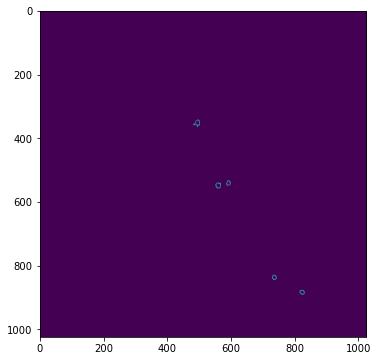

In [11]:
C=plot_matches(sessions[0],sessions[1],ref_inds[:5],target_inds[:5],2)

In [32]:
len(ref_inds)

222

In [8]:
sessions[0]